In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os

In [3]:
import glob

In [4]:
import hybrid_utils

In [5]:
import waveform_generator

/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2023/hms/hybrid_module_dev/waveform_generator.py:4: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [6]:
modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]

In [7]:
filenames = glob.glob("/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/*.h5")
filenames

['/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/ExtrapStrain_RIT-BBH-0198-n140.h5',
 '/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/ExtrapStrain_RIT-BBH-0001-n100.h5',
 '/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/ExtrapStrain_RIT-BBH-0112-n100.h5']

In [8]:
filenames[0].split('/')[-1].split('.h5')[0]

'ExtrapStrain_RIT-BBH-0198-n140'

In [9]:
wfs={}
for filename in filenames:
    name = filename.split('/')[-1].split('.h5')[0]
    # sample spacing in units of M for output NR time series
    delta_t=0.1
    wfs[name] = waveform_generator.get_hdf5_strain(filename, modes, delta_t)
    
    print(wfs[name]['metadata'])


{'q': 1.000000000003392, 'filename': '/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/ExtrapStrain_RIT-BBH-0198-n140.h5', 'M': 0.999999831790954, 'spin1z': 0.0, 'spin2z': 0.0}
{'q': 1.000000000002262, 'filename': '/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/ExtrapStrain_RIT-BBH-0001-n100.h5', 'M': 1.0000010040396652, 'spin1z': -1.61631163233578e-06, 'spin2z': -1.61819600201222e-06}
{'q': 1.0000000016262753, 'filename': '/Users/sebastian.khan/personal/data/RIT_RAW_2024/simulations-ccrg-onQ5YCvq4t/Data/ExtrapStrain_RIT-BBH-0112-n100.h5', 'M': 0.999983268037154, 'spin1z': 5.00451025822305e-06, 'spin2z': 5.00644709061815e-06}


(-100.0, 100.0)

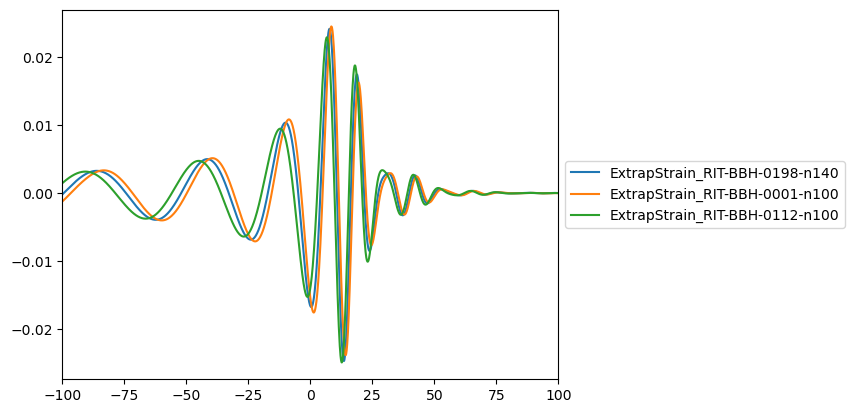

In [10]:
plt.figure()
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['hlm'][3,2].real, label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

In [11]:
# align so that peak of 22 is at t=0
for k in wfs.keys():
    print(k)
    wf = wfs[k]
    t = wf['t']
    hlm = wf['hlm']

    max_idx = np.argmax(np.abs(hlm[2,2]))
    max_time = t[max_idx]
    t_new = t-max_time

    # align so that phase of 22 is 0 at t=0
    phi_ref_22 = np.unwrap(np.angle(hlm[2,2]))[max_idx]
    phi_ref_orb = phi_ref_22/2

    hlm_new = {}
    for mode in modes:
        m = mode[1]
        amp = np.abs(hlm[mode])
        phase = np.unwrap(np.angle(hlm[mode]))
        phase = phase - m*phi_ref_orb
        hlm_new[mode] = amp * np.exp(1.j*phase)


    # save
    wfs[k]['t'] = t_new
    wfs[k]['hlm'] = hlm_new








ExtrapStrain_RIT-BBH-0198-n140
ExtrapStrain_RIT-BBH-0001-n100
ExtrapStrain_RIT-BBH-0112-n100


In [12]:
# cut end noise
for k in wfs.keys():
    wf = wfs[k]
    t = wf['t']
    hlm = wf['hlm']

    mask = t < 150
    t_new = t[mask]
    hlm_new = {}
    for mode in modes:
        hlm_new[mode] = hlm[mode][mask]
        

    # save
    wfs[k]['t'] = t_new
    wfs[k]['hlm'] = hlm_new


(-100.0, 100.0)

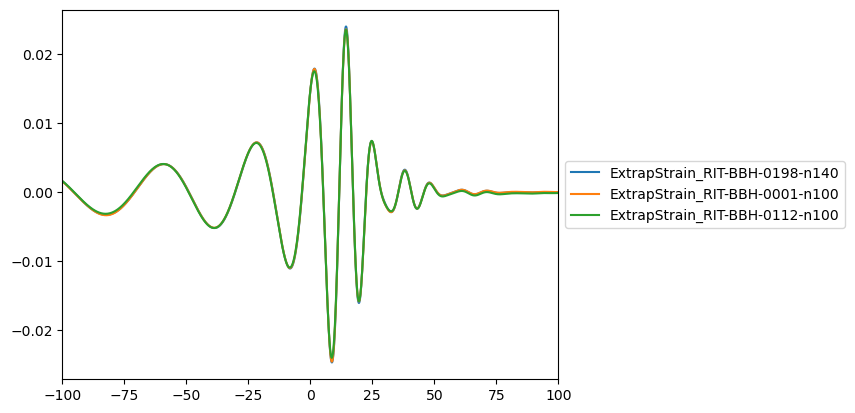

In [13]:
plt.figure()
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['hlm'][3,2].real, label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

In [14]:
for k in wfs.keys():
    wfs[k] = hybrid_utils.compute_amplitude(wfs[k])
    wfs[k] = hybrid_utils.compute_phase(wfs[k])
    # wfs[k] = hybrid_utils.compute_frequency(wfs[k], filter_params={'window_length':1000, 'polyorder':2})
    wfs[k] = hybrid_utils.compute_frequency(wfs[k])

(-1.0, 1.0)

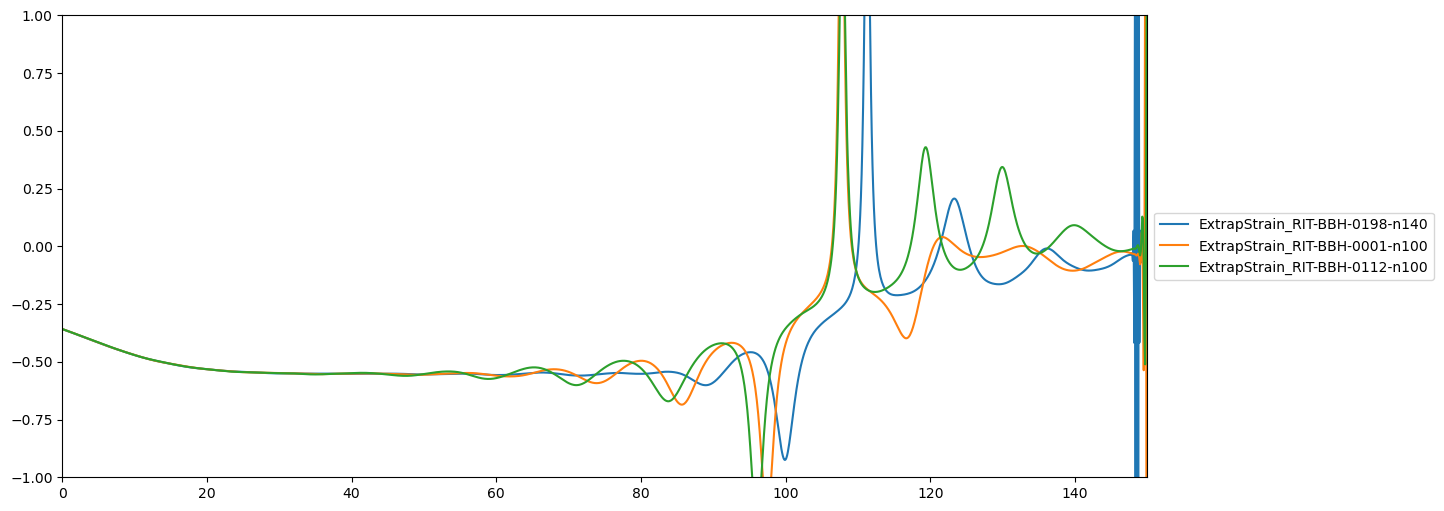

In [15]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['freq'][2,2], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 150)
plt.ylim(-1,1)
# plt.yscale('log')

(-1.0, 1.0)

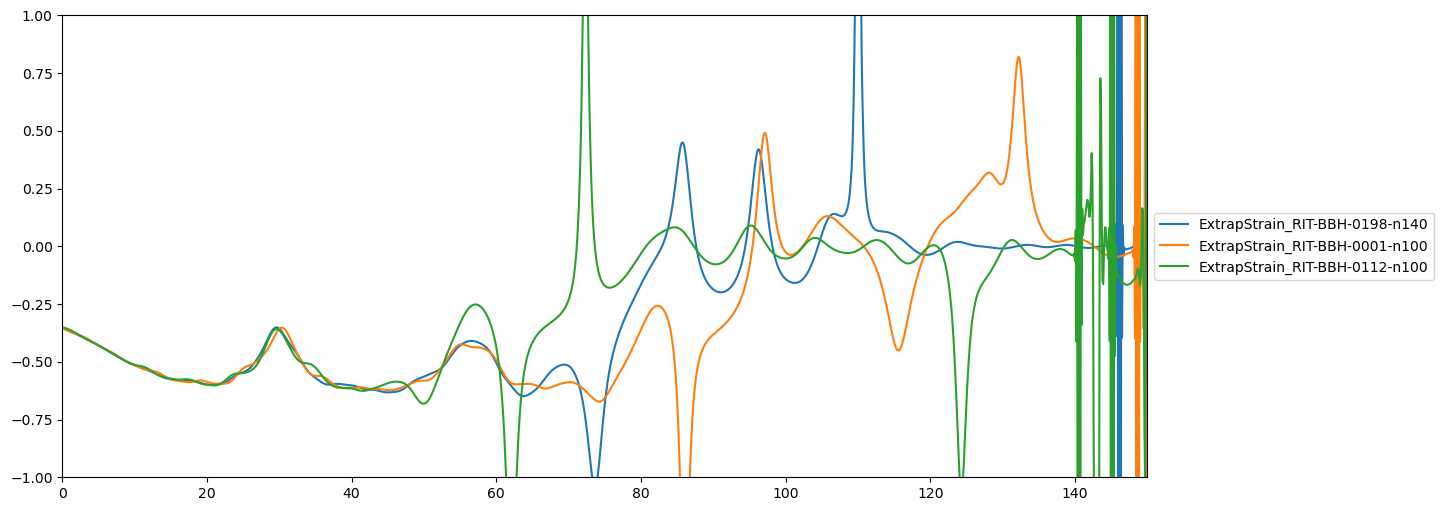

In [16]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['freq'][3,2], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 150)
plt.ylim(-1,1)
# plt.yscale('log')

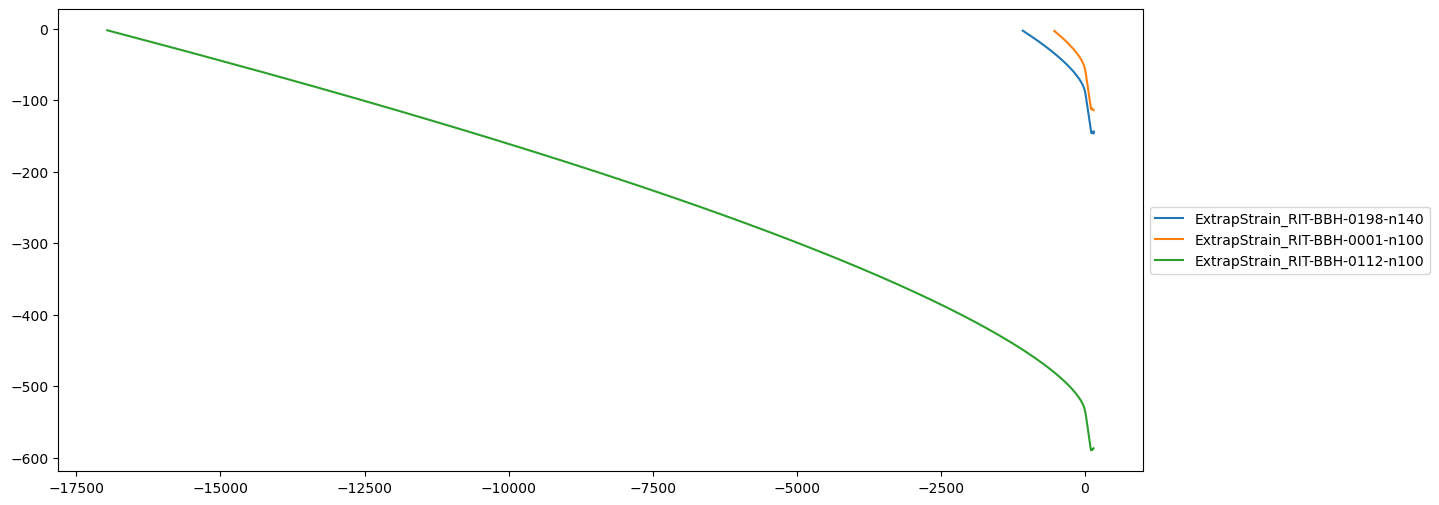

In [17]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['phase'][2,2], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)
# plt.yscale('log')

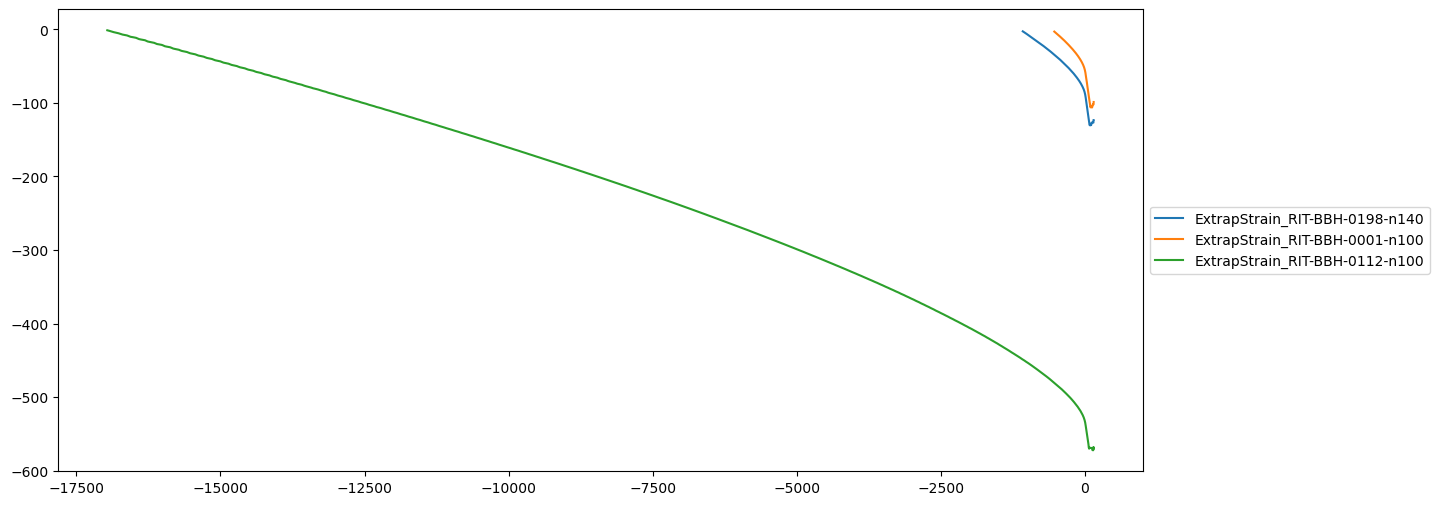

In [18]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['phase'][3,2], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)
# plt.yscale('log')

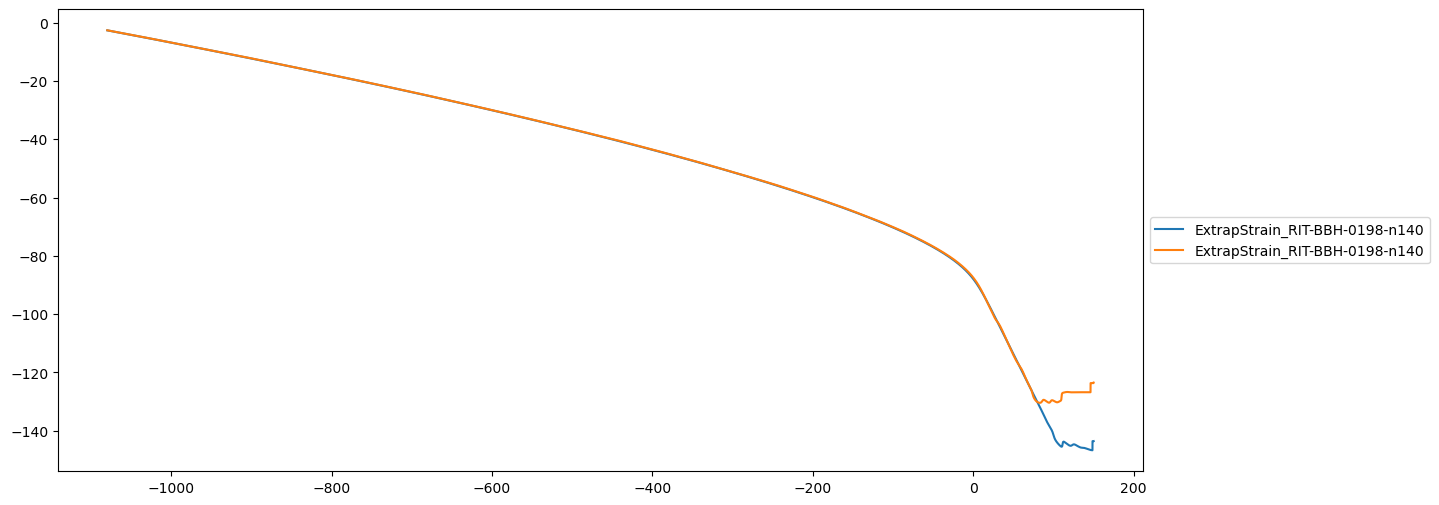

In [19]:
plt.figure(figsize=(14,6))
k = 'ExtrapStrain_RIT-BBH-0198-n140'
plt.plot(wfs[k]['t'], wfs[k]['phase'][2,2], label=k)
plt.plot(wfs[k]['t'], wfs[k]['phase'][3,2], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 100)
# plt.yscale('log')

(-0.01, 0.01)

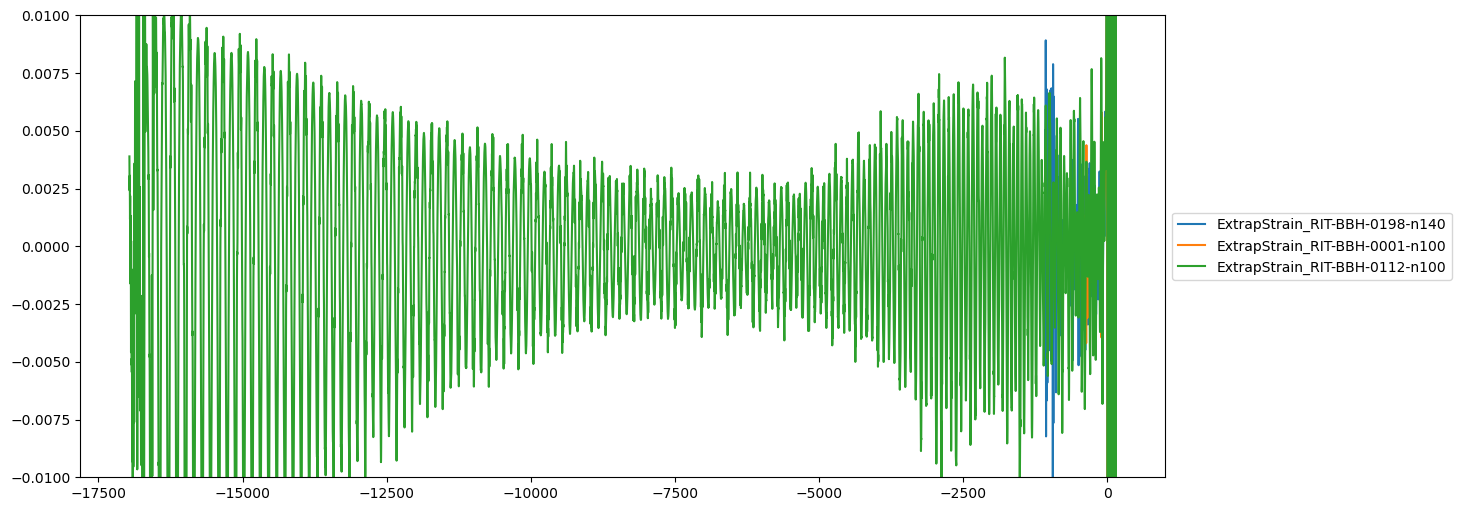

In [20]:
l=3
m=2
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], wfs[k]['freq'][l,m]-m*wfs[k]['freq'][2,2]/2, label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-300, 100)
# plt.ylim(-0.1,0.1)
plt.ylim(-0.01,0.01)
# plt.yscale('log')

In [21]:
# here we compute
# delta_phi = phi_lm - m*phi_22/2
# we unwrap delta_phi
# then we take mod 2pi
# then we try and fix cases that fail to unwrap by subtracting 2pi from cases where this is > 1
# not sure if the is correct though...

l = 3
m = 2

delta_phis = {}
for k in wfs.keys():
    # my def
    delta_phis[k] = np.mod(np.unwrap(wfs[k]['phase'][l,m]-m*wfs[k]['phase'][2,2]/2), 2*np.pi)
    # XHM def
    # delta_phis[k] = np.mod(np.unwrap(2*wfs[k]['phase'][l,m]-m*wfs[k]['phase'][2,2]), 2*np.pi)

for k in delta_phis.keys():
    delta_phi = np.array(delta_phis[k])
    mask = delta_phi > 1
    delta_phi[mask] = delta_phi[mask]-2*np.pi
    delta_phis[k] = delta_phi

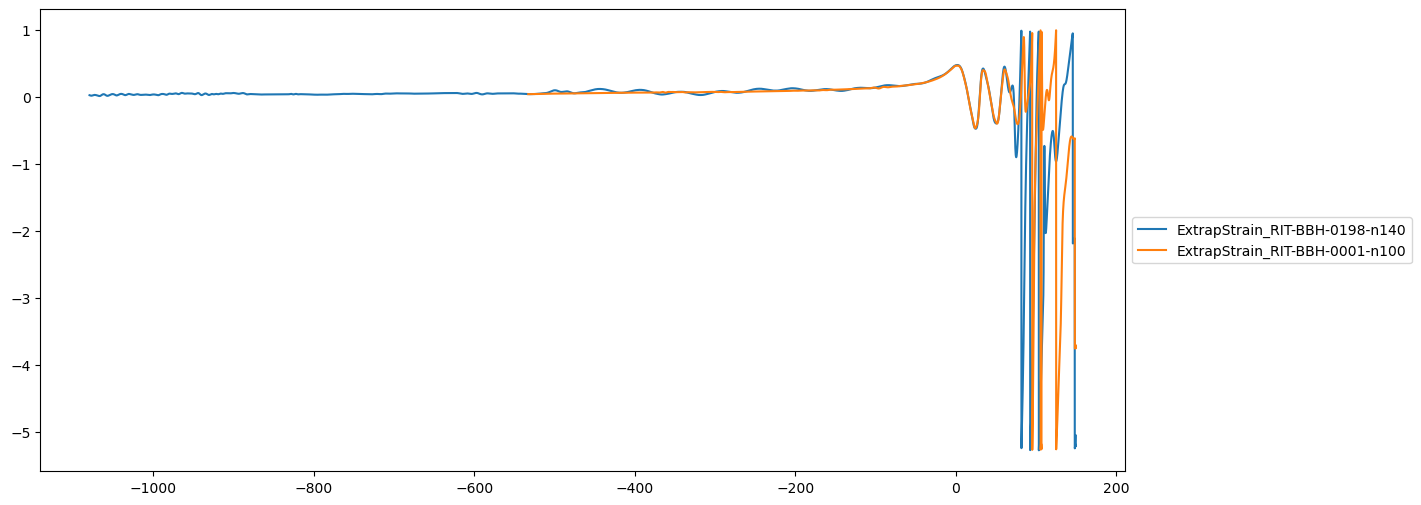

In [22]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    if '0112' not in k:
        plt.plot(wfs[k]['t'], delta_phis[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-4000, 100)
# plt.xlim(-1200, 100)
# plt.ylim(-1,1)
# plt.yscale('log')

# plt.axhline(0, c='k', ls='--')

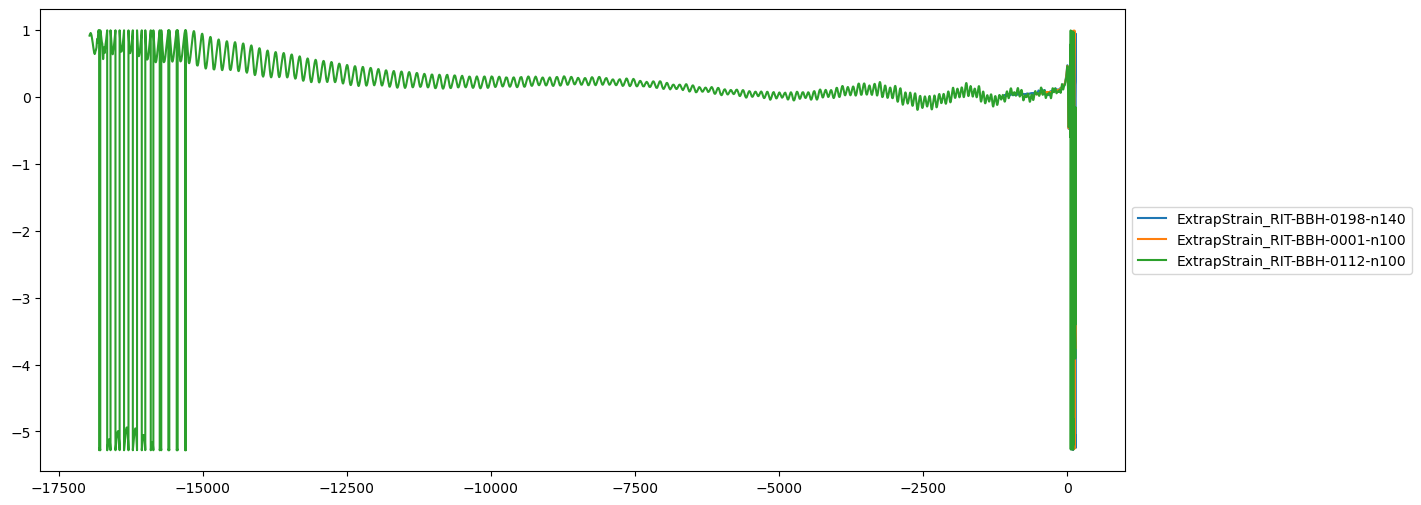

In [23]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], delta_phis[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-4000, 100)
# plt.xlim(-1200, 100)
# plt.ylim(-1,1)
# plt.yscale('log')

# plt.axhline(0, c='k', ls='--')

(-1200.0, 100.0)

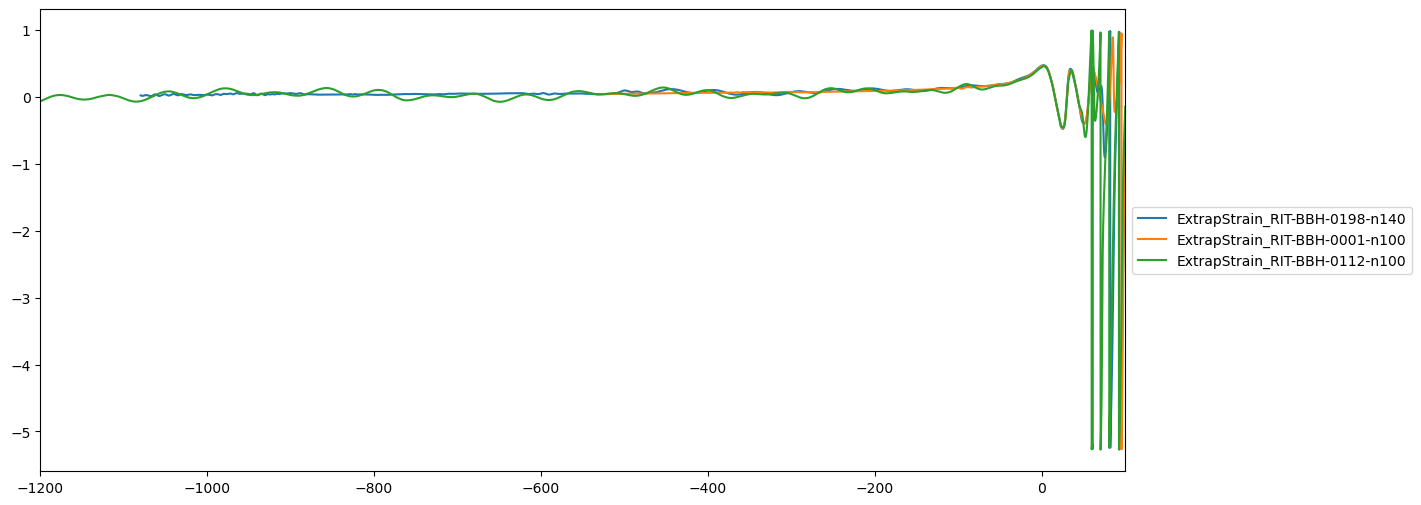

In [24]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], delta_phis[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-4000, 100)
plt.xlim(-1200, 100)
# plt.ylim(-1,1)
# plt.yscale('log')

# plt.axhline(0, c='k', ls='--')

(-0.25, 0.25)

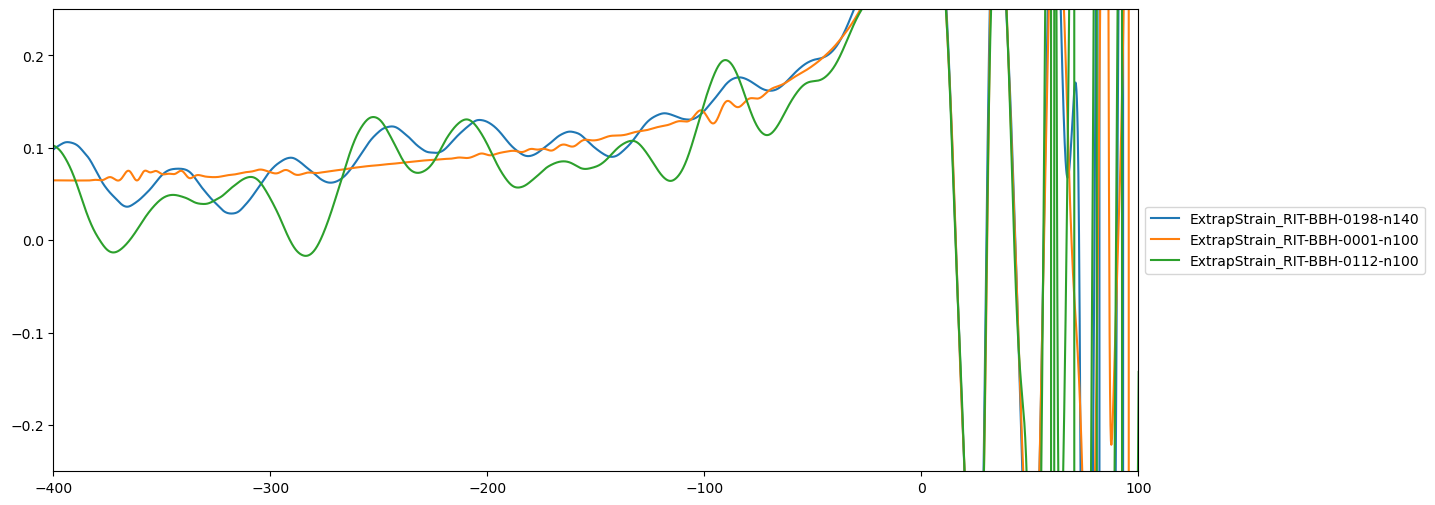

In [25]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], delta_phis[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-400, 100)
plt.ylim(-0.25,0.25)
# plt.ylim(-1,1)
# plt.yscale('log')

# plt.axhline(0, c='k', ls='--')

In [26]:
# here we compute
# delta_phi = phi_lm - m*phi_22/2
# we unwrap delta_phi
# then we take mod 2pi
# then we try and fix cases that fail to unwrap by subtracting 2pi from cases where this is > 1
# not sure if the is correct though...

l = 4
m = 4

delta_phis = {}
for k in wfs.keys():
    # my def
    delta_phis[k] = np.mod(np.unwrap(wfs[k]['phase'][l,m]-m*wfs[k]['phase'][2,2]/2), 2*np.pi)
    # XHM def
    # delta_phis[k] = np.mod(np.unwrap(2*wfs[k]['phase'][l,m]-m*wfs[k]['phase'][2,2]), 2*np.pi)

# for k in delta_phis.keys():
#     delta_phi = np.array(delta_phis[k])
#     mask = delta_phi > 1
#     delta_phi[mask] = delta_phi[mask]-2*np.pi
#     delta_phis[k] = delta_phi

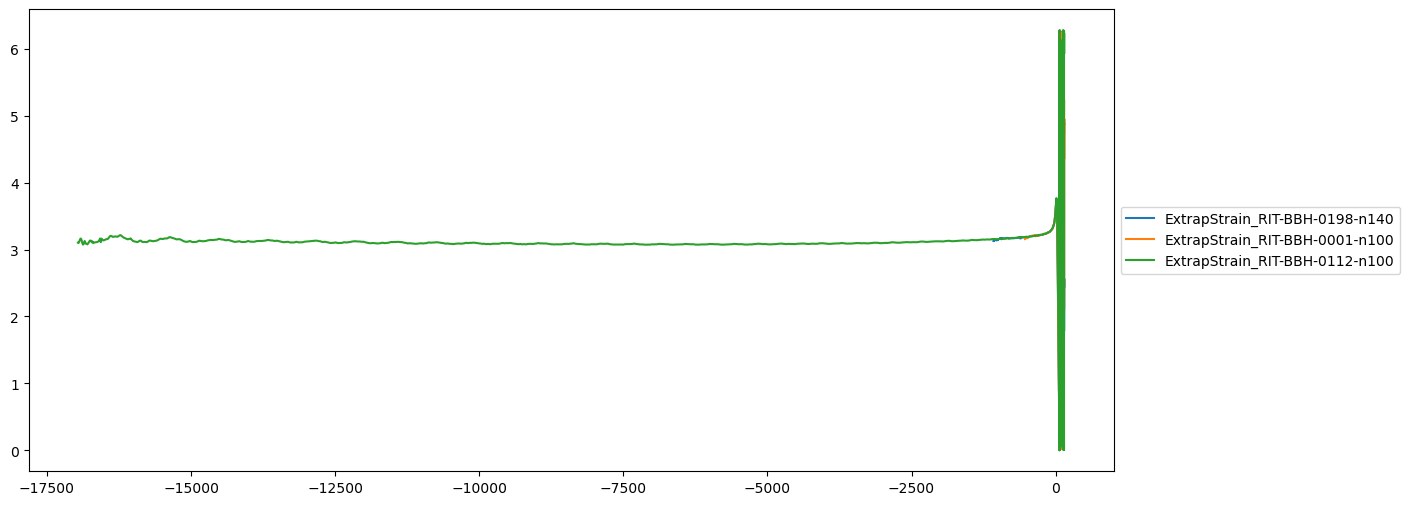

In [27]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], delta_phis[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-200, 100)
# plt.ylim(-1,1)
# plt.yscale('log')

# plt.axhline(0, c='k', ls='--')

(-200.0, 100.0)

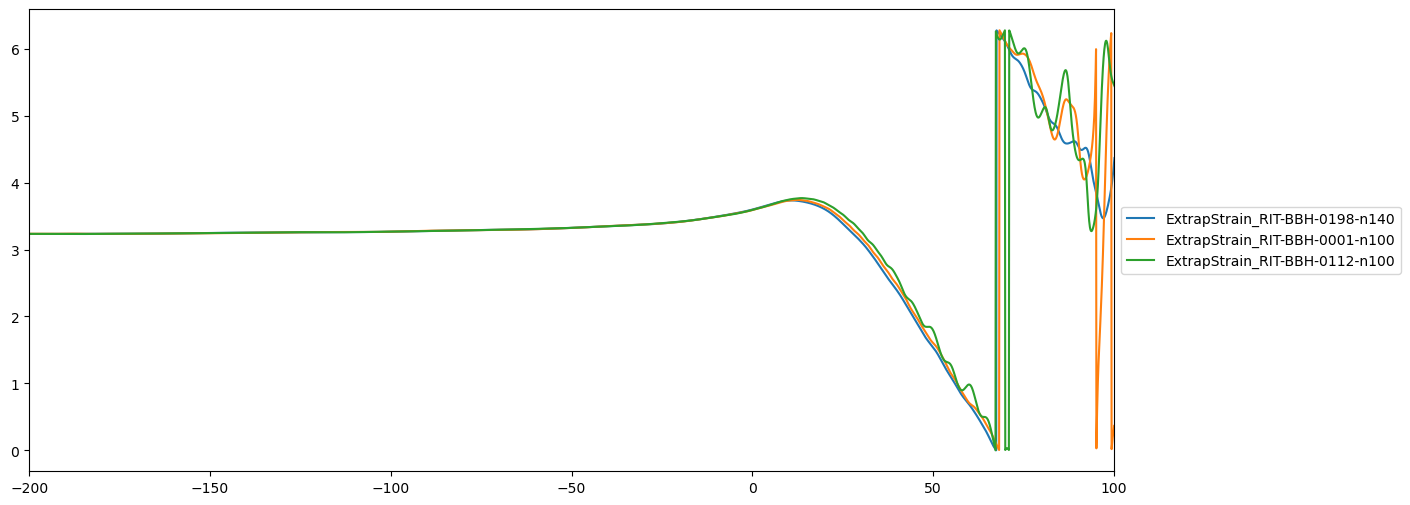

In [28]:
plt.figure(figsize=(14,6))
for k in wfs.keys():
    plt.plot(wfs[k]['t'], delta_phis[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-200, 100)
# plt.ylim(-1,1)
# plt.yscale('log')

# plt.axhline(0, c='k', ls='--')

# output data to compare with other codes

In [42]:
# output_dir = "/Users/sebastian.khan/personal/data/NR_COMPARISON_Q1_NS_32_22_MODE"
# base_name = "RIT"
# for k in wfs.keys():
#     times = wfs[k]['t']
#     phase_22 = wfs[k]['phase'][2,2]
#     phase_32 = wfs[k]['phase'][3,2]
#     output_data = np.c_[times, phase_22, phase_32]
#     output_file = f"{base_name}_{k.replace('_','-')}.npy"
#     np.save(os.path.join(output_dir, output_file), output_data)